# Social Network Community Analysis Using NetworkX
Apoorva Havanur, ahavanur

In this tutorial we will be taking a more in-depth looking into Python's NetworkX library, and using it to analyze Youtube communities to better understand online social networks. 

## Background
In today's increasingly social world, social media and networking sites such as Facebook, Instagram, and Twitter have taken on an important presence in people's lives. Therefore, it's essential to learn about the basics of how to analyze networks. Luckily, the networkx Python package offers us a wide variety of functions and data structures that make analyzing networks much easier. This tutorial will go more in-depth than the brief tutorial we got during class, and show off some more of the features of Networkx. 

## Installing Packages
If you don't have networkx installed, simply run 'pip install networkx' on your commandline. For added analysis, we will also be downloading pandas and matplotlib, both of which we have used in class before this. 

In [2]:
import networkx as nx
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
# AUTOLAB_IGNORE_START
%matplotlib inline
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (15.0, 10.0) # you should adjust this to fit your screen

## Processing Inputs
Now for some data. We will be getting our data from the Stanford Large Network Dataset Collection. Download each of these files [here](https://snap.stanford.edu/data/com-Youtube.html). Then, read in each of the files to python. Specifically, we will be looking at the Youtube dataset, which has two types of data that we're interested in: 
1. A collection of friendships between Youtube users: 'com-youtube.ungraph.txt'
2. A collection of user-defined groups ("communities"): 'com-youtube.all.cmty.txt'


In [3]:
edges = 'com-youtube.ungraph.txt'
commData = open('com-youtube.all.cmty.txt', 'r')

Let's start with our communities. We want to efficiently be able to look up a community, and, eventually, look up what communities a particular user is part of. To do so, we will maintain two dictionaries, parsing through the communities data and putting into two maps. 

In [4]:
communities = dict() #each key is a different community
cName = 0 #each community assigned a different int, starting with 0
users = dict()
for community in commData.readlines():
    members = set(list(map(lambda x: int(x), community.split("\t"))))
    #first, split the line into individual users, then convert each user into an int
    communities[cName] = members
    for member in members:
        if member not in users:
            users[member] = set()
        users[member].add(cName) #add the community they were found in
    cName +=1 
commData.close()
print(len(communities))
print(len(users))

16386
52675


Looking at our output above, it appears that our data comes with approximately 52,000 users and 16,000 communities, or about 3.25 members per community. Not very large! We'll dig more into the exact distribution later.

Creating dictionaries is a little tedious, but luckily, creating the graph is very straightforward. We'll use networkx's builting `read_edgelist()` method to read in our edges file, specifying which lines to ignore and how to differentiate the two nodes that make up each edge.  

In [5]:
G = nx.read_edgelist(edges, comments= "#", delimiter = "\t")

To match how we've handled users above, we want our nodes to be represented as ints. We can easily do this with networkx's built-in `relabel_nodes` function as well and the same lambda function as before.

In [6]:
G = nx.relabel_nodes(G,lambda x: int(x))

Almost done! A quick look at our graph reveals just how massive it is:

In [7]:
print((G.number_of_nodes()))
print((G.number_of_edges()))

1134890
2987624


We want to restrict our graph just to the users that we are interested in, i.e the ones we have community data for. So, we'll take the subgraph containing only our community users.

In [8]:
G = G.subgraph(users.keys())
print(len(users.keys()))
print(len(G.nodes()))

52675
52675


We're also going to assign the communities that each user is a part of to their node in the graph by using the networkx method `set_node_attributes`

In [9]:
nx.set_node_attributes(G, users, 'communities')
print(G.node[1]['communities'])

{16, 1}


Much better! Now we can start looking at the data in more detail

## Describing Communities
Let's begin by doing some exploratory data analysis on the communities themselves. First, let's look at how big different communities are by translating our dictionary into a pandas Series object:

In [10]:
comm_size = pd.Series([len(communities[v]) for v in sorted(communities.keys())]) #we sort so that we keep track of each community based on index

First we take a quick snapshot of the data in a summary, including looking at different quantiles. 

In [11]:
print(pd.Series.describe(comm_size, percentiles = [0.1*i for i in range(11)]))

count    16386.000000
mean         7.884902
std         42.288362
min          2.000000
0%           2.000000
10%          2.000000
20%          2.000000
30.0%        2.000000
40%          2.000000
50%          3.000000
60.0%        3.000000
70%          4.000000
80%          6.000000
90%         12.000000
100%      3001.000000
max       3001.000000
dtype: float64


The mean community has approximately 8 members, with the median having only 3, and the 90th percentile around 12, with the largest with over 3000. This suggest that our data contains several large outliers, which we can also inspect visually:

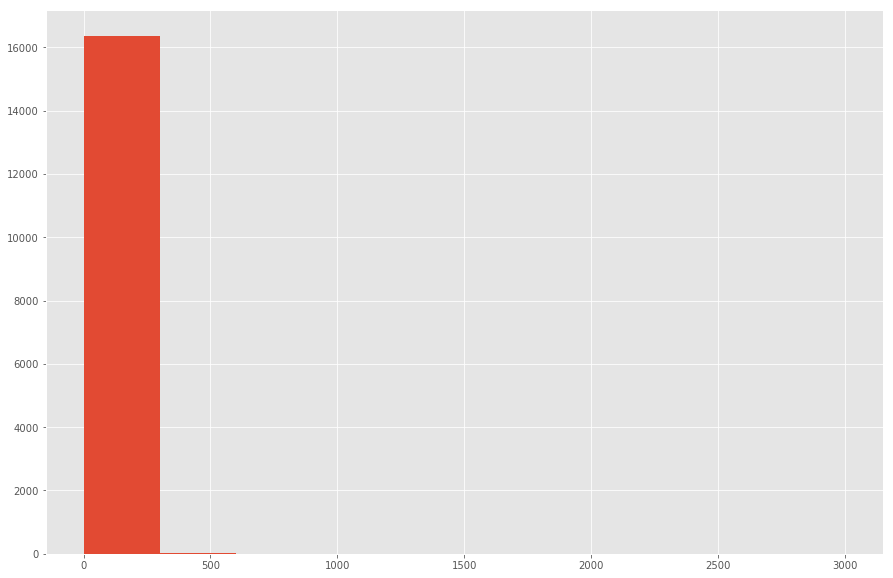

In [12]:
plt.hist(comm_size)
plt.show()

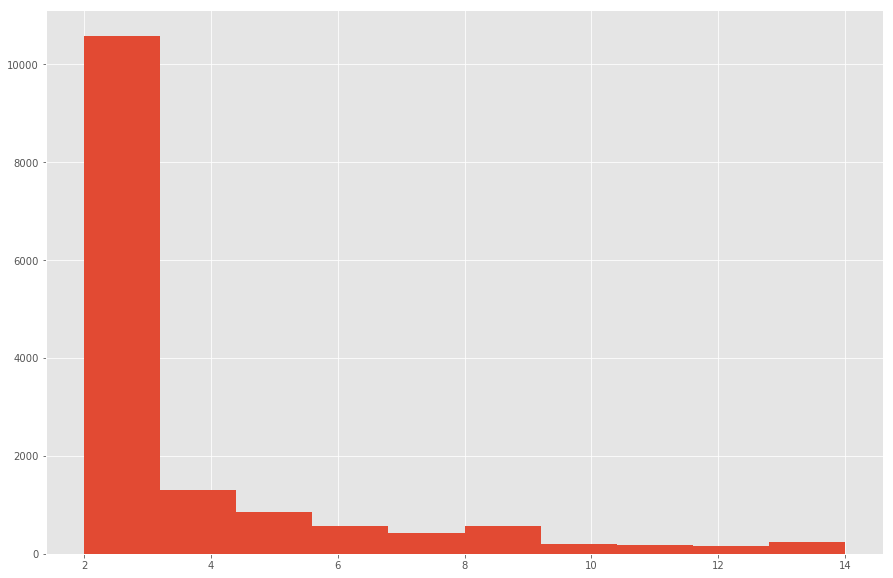

In [13]:
plt.hist(comm_size[~(comm_size >= 15)]) #removing any community with more than 15 members
plt.show()

Similarly, we can look at how many communities each user is involvement.

In [14]:
user_memberships = pd.Series([len(users[v]) for v in sorted(users.keys())]) #we sort so that we keep track of each community based on index

In [15]:
print(pd.Series.describe(user_memberships, percentiles = [0.1*i for i in range(11)]))

count    52675.000000
mean         2.452814
std          4.807589
min          1.000000
0%           1.000000
10%          1.000000
20%          1.000000
30.0%        1.000000
40%          1.000000
50%          1.000000
60.0%        1.000000
70%          2.000000
80%          3.000000
90%          5.000000
100%       227.000000
max        227.000000
dtype: float64


On average users are in only 2 groups, with the maximum being 170(!!) and the median being 1. We can see that this data also seems to contain a lot of outliers, as evidenced by the histogram

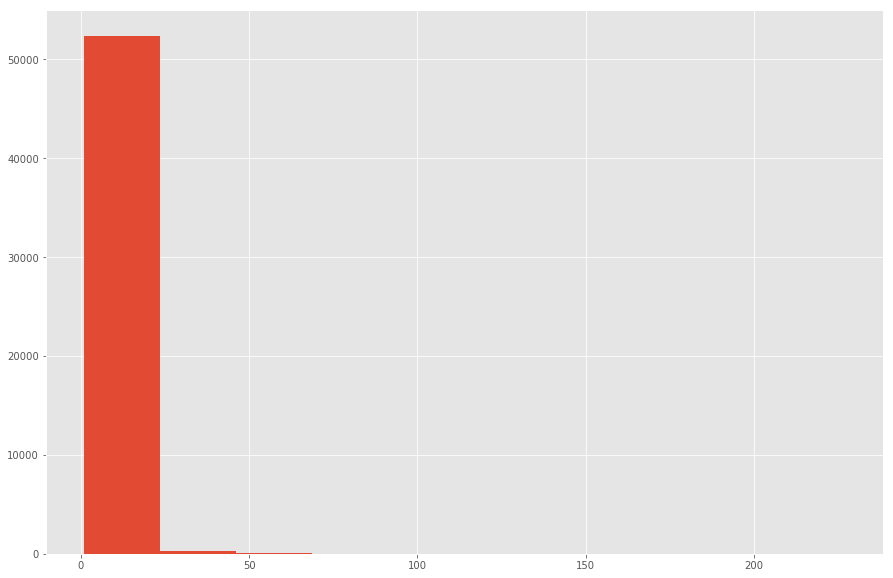

In [16]:
plt.hist(user_memberships) #removing any community with more than 15 members
plt.show()

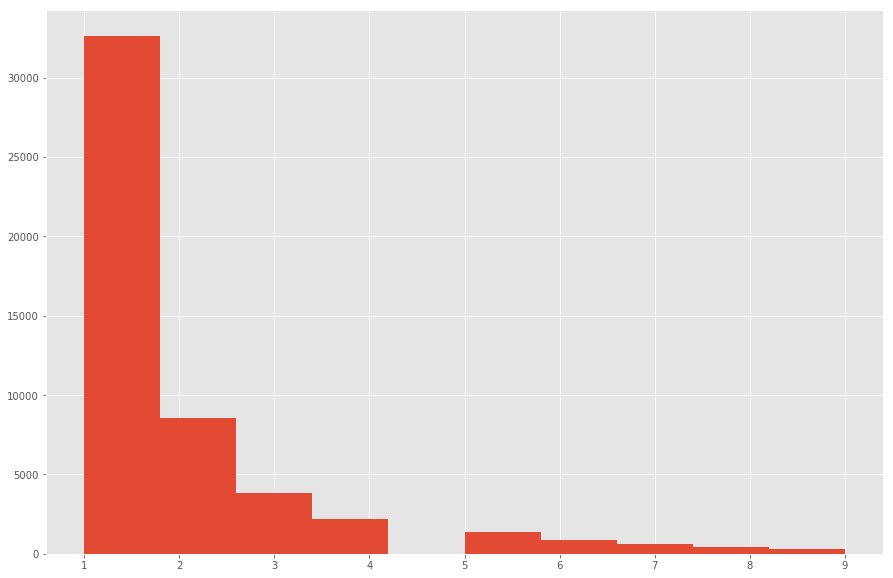

In [17]:
plt.hist(user_memberships[~(user_memberships >= 10)]) #removing any users in more than 10 communities
plt.show()

So we know that most users are part of very few groups, and that most communities have only a few members. But do certain communities have more "social" members than others? To determine this, we look at the members of a given community, and the average number of other communities they are a part of, and look at the results. To handle the outliers, we'll remove the maximum from each group.

count    16386.000000
mean         6.815112
std         18.104777
min          0.000000
0%           0.000000
10%          0.000000
20%          0.000000
30.0%        0.333333
40%          1.000000
50%          2.000000
60.0%        3.000000
70%          5.000000
80%          8.000000
90%         15.101449
100%       226.000000
max        226.000000
dtype: float64


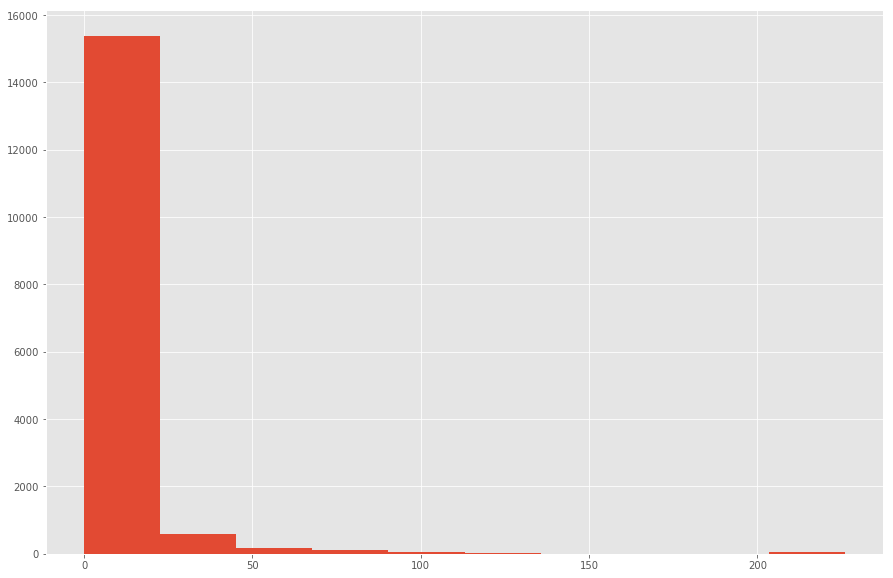

In [18]:
involvement = []
for community in sorted(communities.keys()):
    members = communities[community]
    total = list(map(lambda x: len(users[x])-1, members))
    community_involvement = (sum(total)-max(total))/(len(members)-1) #average outside involvement
    involvement.append(community_involvement)
involvement = pd.Series(involvement)
print(pd.Series.describe(involvement, percentiles = [0.1*i for i in range(11)]))
plt.hist(involvement)
plt.show()


For each community, the median number of other communities that it's users are involved with is about 1.5, with 10% communities having an average greater than 10. This suggests that not all communities are created equal - while some groups are relatively insular, some are filled with members that split their time between that community and a variety of other. 

Does the size of the group affect how insular it's members are? We can determine this by creating a scatterplot comparing the two:

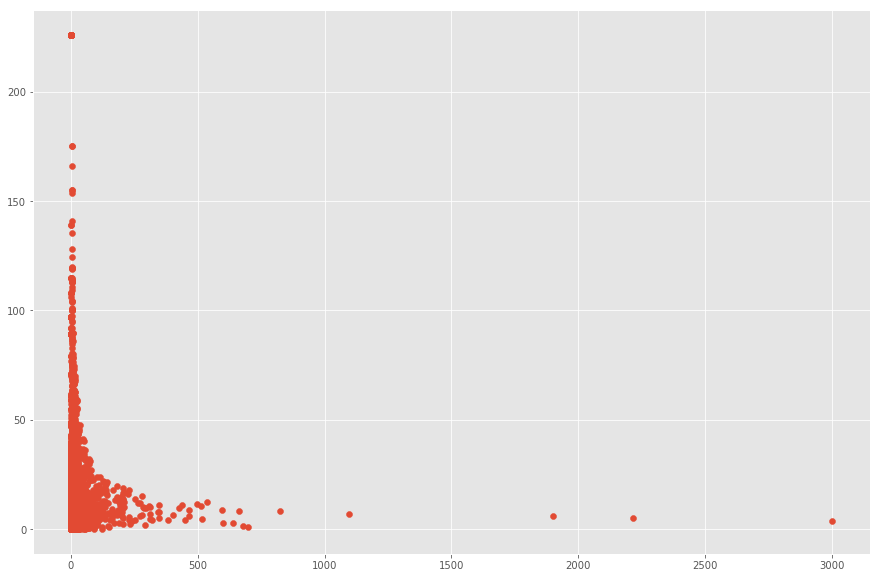

In [19]:
plt.scatter(comm_size, involvement)
plt.show()

Let's exclude the outliers and zoom in on just the part near the origin:

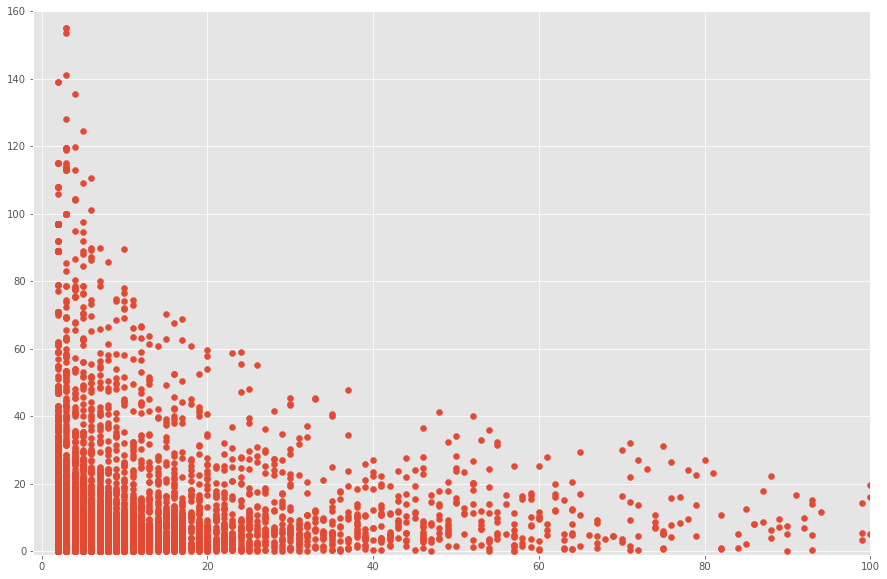

In [20]:
plt.scatter(comm_size, involvement)
plt.xlim(-1, 100)
plt.ylim(-1, 160)
plt.show()

While not a perfectly linear relationship, it does appear counterintuitvely that involvement in other communities is negatively correlated with the size of the community itself. This suggests that the larger communities make up a larger part of a user's overall involvement, while smaller ones are more likely to have users that are engaged in numerous other communities.

## Network Analysis
Now that we have a slightly better picture of the communities that our users are in, it's time to look at the user's themselves. Networkx is filled to the brim with many useful algorithms to help us describe our network. 

We'll begin by trying to better describe our overall social network. First we'll look at the degree distribution of our graph

count    52675.000000
mean        12.090441
std         35.260511
min          1.000000
0%           1.000000
10%          1.000000
20%          1.000000
30.0%        2.000000
40%          3.000000
50%          4.000000
60.0%        5.000000
70%          8.000000
80%         13.000000
90%         25.000000
100%      1928.000000
max       1928.000000
dtype: float64


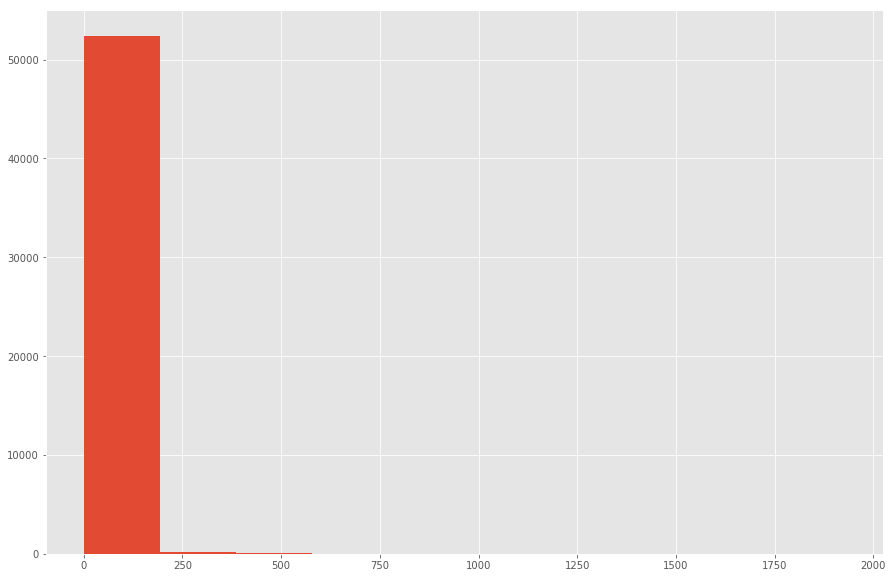

In [21]:
degrees = pd.Series(list(map(lambda x: x[1], G.degree())))
print(pd.Series.describe(degrees, percentiles = [0.1*i for i in range(11)]))
plt.hist(degrees)
plt.show()

It seems like our graph is very sparse: 50% of users have 4 or less connections to other users and less than 10% have more than 25 (compared to social networks like Facebook, where the average user has more than 100 friends). 

Given the size of our graph, it's pretty much impossible to try to visualize the entire thing. However, we can visualize different subgraphs based on different communities. 

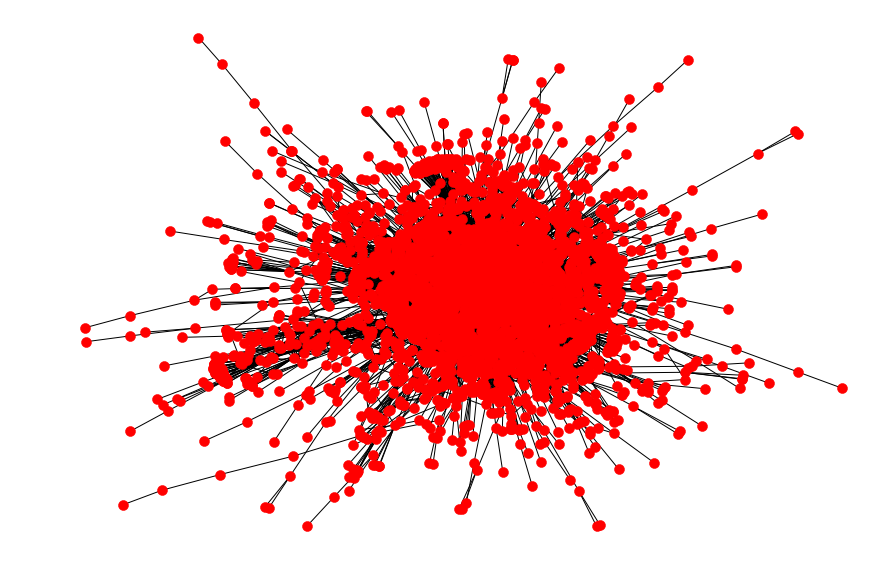

In [22]:
largestCommunity = pd.Series.idxmax(comm_size) #get the index (i.e the community number) of the largest community
largestCommunitySubgraph = G.subgraph([n for n,attrdict in G.node.items() if (largestCommunity in attrdict['communities'])])
nx.draw_networkx(largestCommunitySubgraph, with_labels=False, node_size = 100)
limits=plt.axis('off')

We can also look at outside involvement of members of a given community in the same way

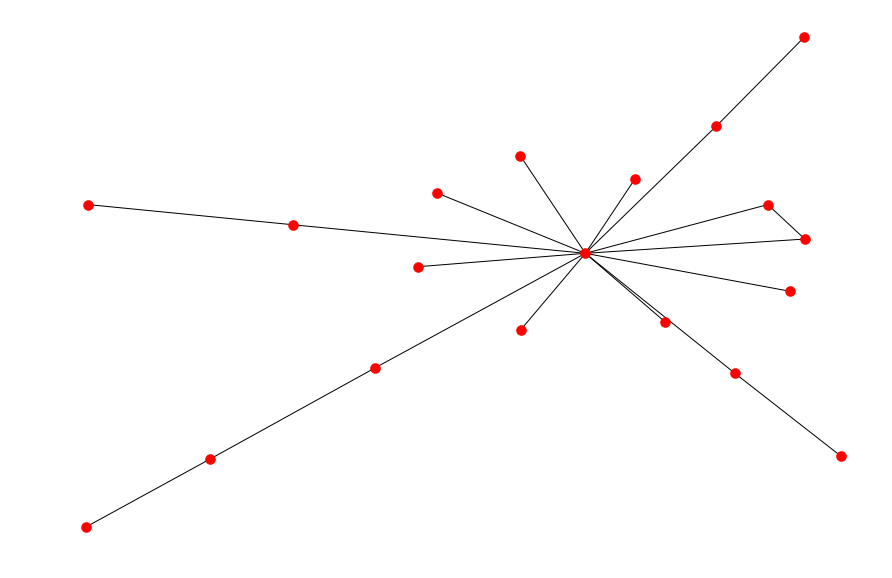

In [23]:
medianInvolvement = involvement[involvement == pd.Series.median(involvement)].index[0]
medianInvolvementSubgraph = G.subgraph([n for n,attrdict in G.node.items() if (medianInvolvement in attrdict['communities'])])
nx.draw_networkx(medianInvolvementSubgraph, with_labels=False, node_size = 100)
limits=plt.axis('off')

Let's go a step further. Within each community, we can look at some of the characteristics of the friend graph of their users in more details, such as the [average clustering coefficient](https://en.wikipedia.org/wiki/Clustering_coefficient), the average degree, and the density of the graph. To make our results more relevant, we'll ignore small communities with less than 5 members by just adding `None`

In [24]:
avg_clustering = []
avg_degrees = []
avg_density = []
for community in sorted(communities.keys()):
    subgraph = G.subgraph(list(communities[community]))
    if subgraph.number_of_nodes() <= 5:
        avg_clustering.append(None)
        avg_degrees.append(None)
        avg_density.append(None)
    else:
        avg_clustering.append(nx.average_clustering(subgraph))
        degrees = subgraph.degree()
        avg_degrees.append(sum(map(lambda t: t[1], list(degrees)))/len(degrees))
        avg_density.append(nx.density(subgraph))
avg_clustering = pd.Series(avg_clustering)
avg_degrees = pd.Series(avg_degrees)
avg_density = pd.Series(avg_density)

count    3647.000000
mean        0.273367
std         0.226837
min         0.000000
0%          0.000000
10%         0.000000
20%         0.000000
30.0%       0.119944
40%         0.185185
50%         0.250000
60.0%       0.308025
70%         0.382297
80%         0.477458
90%         0.601190
100%        1.000000
max         1.000000
dtype: float64


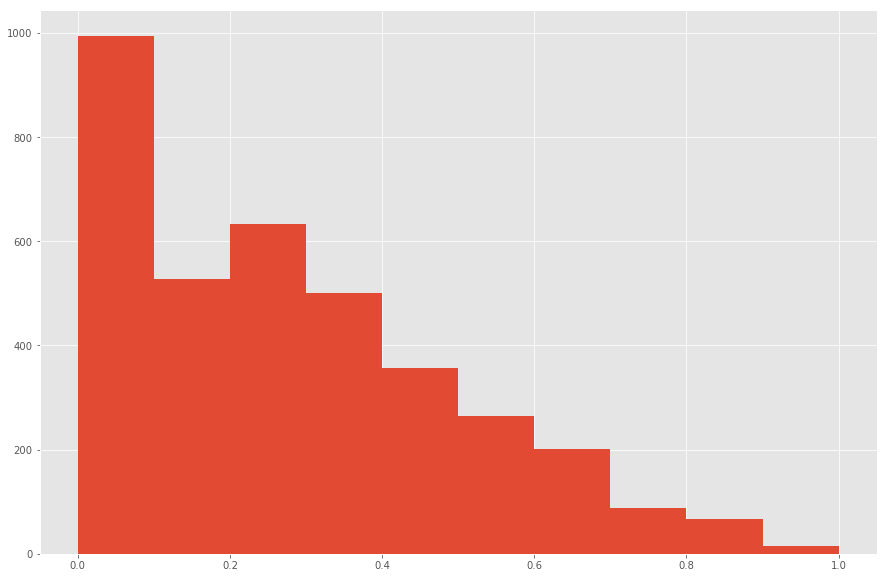

In [50]:
print(pd.Series.describe(avg_clustering.dropna(), percentiles = [0.1*i for i in range(11)]))
plt.hist(avg_clustering.dropna())
plt.show()

The median custering coefficient is 0.25, with 90% having a coefficient less than 0.601. This suggests that communities are relatively interconnected with one another, and that some communtiy members are likely to be friend with one another. 

count    3647.000000
mean        2.782161
std         1.196712
min         1.666667
0%          1.666667
10%         1.714286
20%         2.000000
30.0%       2.000000
40%         2.250000
50%         2.444444
60.0%       2.666667
70%         3.000000
80%         3.421649
90%         4.201356
100%       13.776699
max        13.776699
dtype: float64


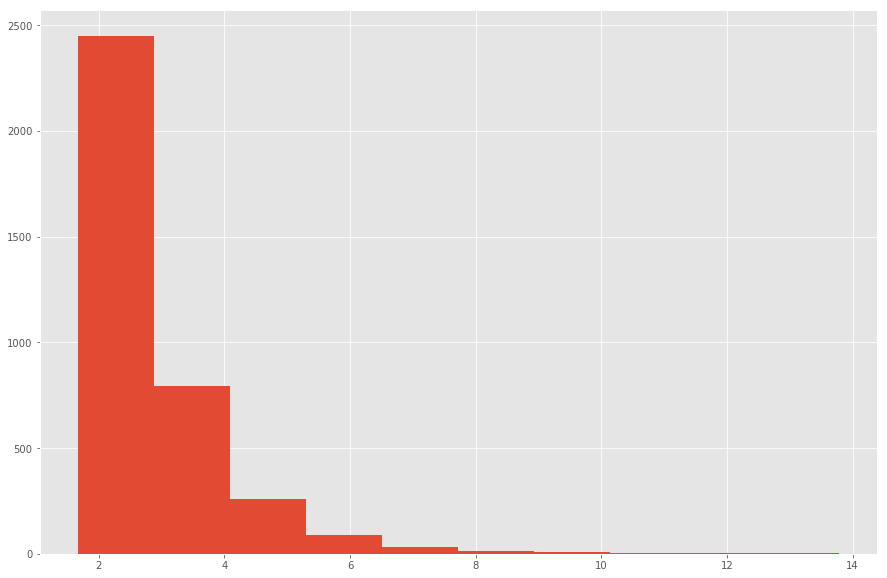

In [26]:
print(pd.Series.describe(avg_degrees.dropna(), percentiles = [0.1*i for i in range(11)]))
plt.hist(avg_degrees.dropna())
plt.show()

Interestingly, although the average clustering component of the graph is high, the average degree in these graphs is quite small, with a mean degree of each node is less than 3. So, it appears that a amjority of a user's friends are in the same community as them. 

count    3647.000000
mean        0.258442
std         0.150791
min         0.001403
0%          0.001403
10%         0.072641
20%         0.123109
30.0%       0.166667
40%         0.209168
50%         0.250000
60.0%       0.285714
70%         0.333333
80%         0.357143
90%         0.442778
100%        1.000000
max         1.000000
dtype: float64


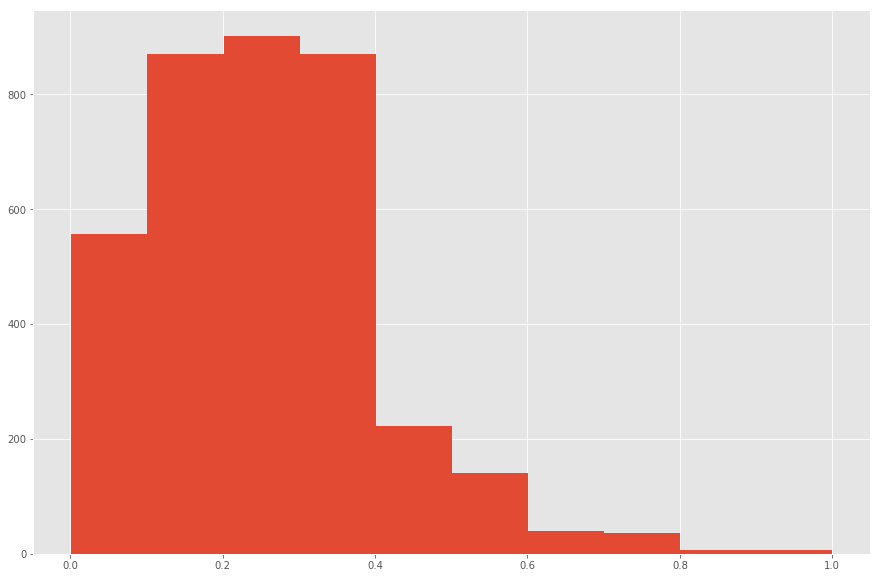

In [27]:
print(pd.Series.describe(avg_density.dropna(), percentiles = [0.1*i for i in range(11)]))
plt.hist(avg_density.dropna())
plt.show()

Similarly, density is relatively high in these communties compared to what we would expect from randomly generated communities. 

0.38872236636127294


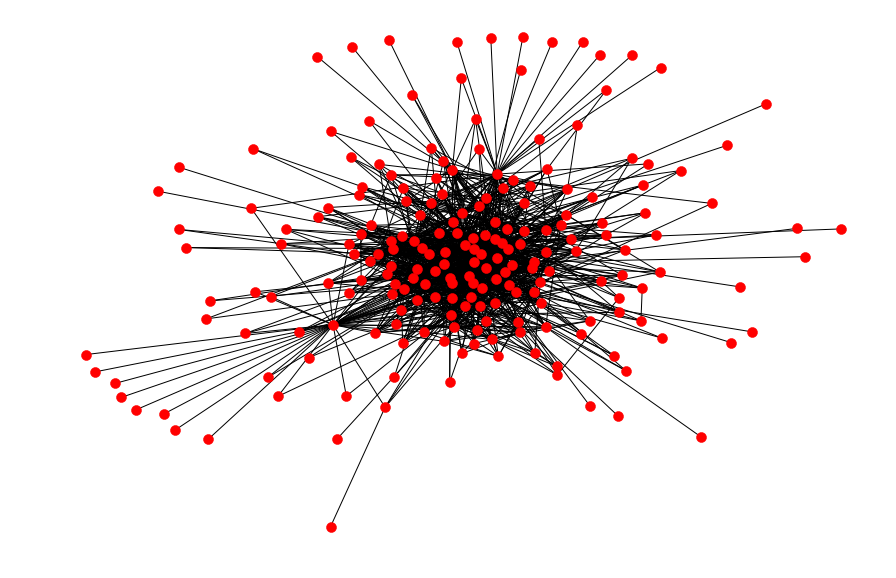

In [42]:
highestDegree = pd.Series.idxmax(avg_degrees) #get the index (i.e the community number) of the largest community
highestDegreeSubgraph = G.subgraph([n for n,attrdict in G.node.items() if (highestDegree in attrdict['communities'])])
nx.draw_networkx(highestDegreeSubgraph, with_labels=False, node_size = 100)
limits=plt.axis('off')
print(nx.average_clustering(highestDegreeSubgraph))

The above graph has a high degree, but also a relatively high density at 30%. We can further explore the relationship between community size and graph statistics in more detail with some scatter plots.

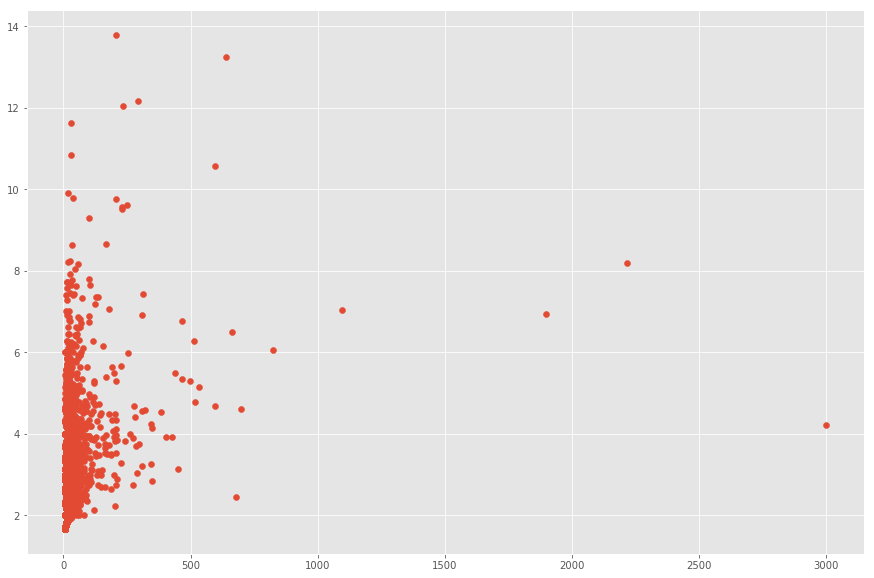

In [30]:
plt.scatter(comm_size, avg_degrees)
plt.show()

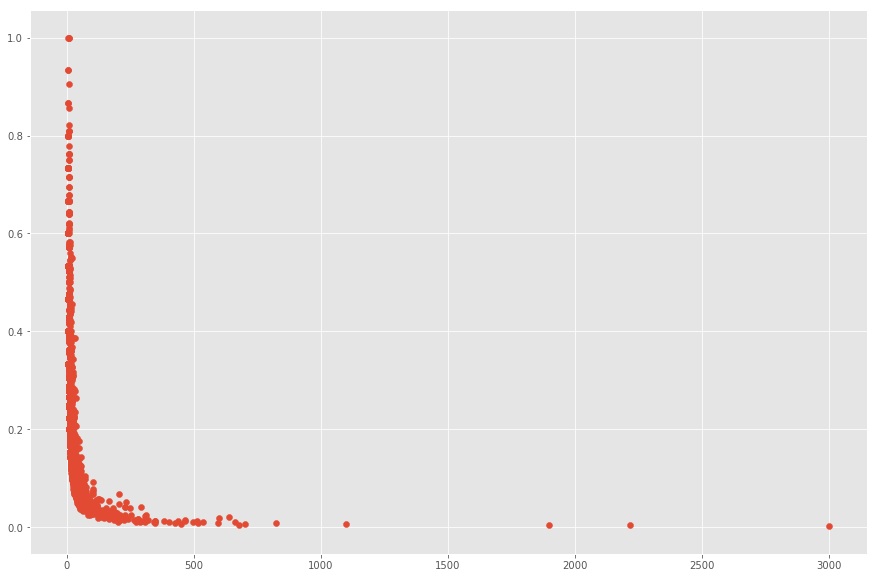

In [31]:
plt.scatter(comm_size, avg_density)
plt.show()

## Exploring Different Graph Types: Weighted Graph
Networkx allows us to improve our analysis by adding weights to the edges between two users. In our case, lets weight each edge based on how many communities a user and their friend have in common.

In [43]:
#To do: who should they be friends with that they aren't?
H = nx.Graph() #create new graph
for user in users:
    friends= G.neighbors(user)
    for friend in friends:
        if user != friend:
            if not H.has_edge(user, friend):
                communityCount = len(users[user].intersection(users[friend]))
                H.add_edge(user, friend, weight=communityCount)

We can now look at the average of the weighted edge of each node, which would allow us to say see the average number of communities two friends in the network share in common.

In [47]:
avg_weighted_degree = []
for community in sorted(communities.keys()):
    subgraph = H.subgraph(list(communities[community]))
    n = subgraph.number_of_nodes()
    if n <= 5:
        avg_weighted_degree.append(None)
    else:
        weights = list(map(lambda x: x[1], subgraph.degree(weight='weight')))
        avg_weighted_degree.append(sum(weights)/n)
avg_weighted_degree = pd.Series(avg_weighted_degree)

count    3647.000000
mean       12.769664
std        20.674912
min         1.666667
0%          1.666667
10%         2.376720
20%         3.250000
30.0%       4.000000
40%         5.200000
50%         6.461538
60.0%       8.200000
70%        10.833657
80%        14.888889
90%        25.043705
100%      236.666667
max       236.666667
dtype: float64


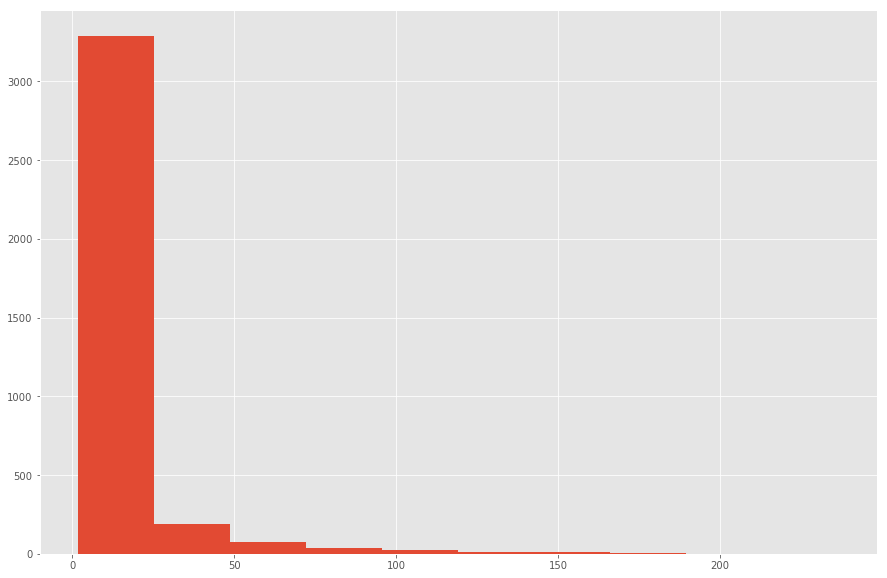

In [48]:
print(pd.Series.describe(avg_weighted_degree.dropna(), percentiles = [0.1*i for i in range(11)]))
plt.hist(avg_weighted_degree.dropna())
plt.show()

On average, two friends in the same network are in 12 communities together, with the median being about half of that, 6.5. Still, it tells us a lot about the nature of these friendships that two friends share so much in common on Youtube with one another.

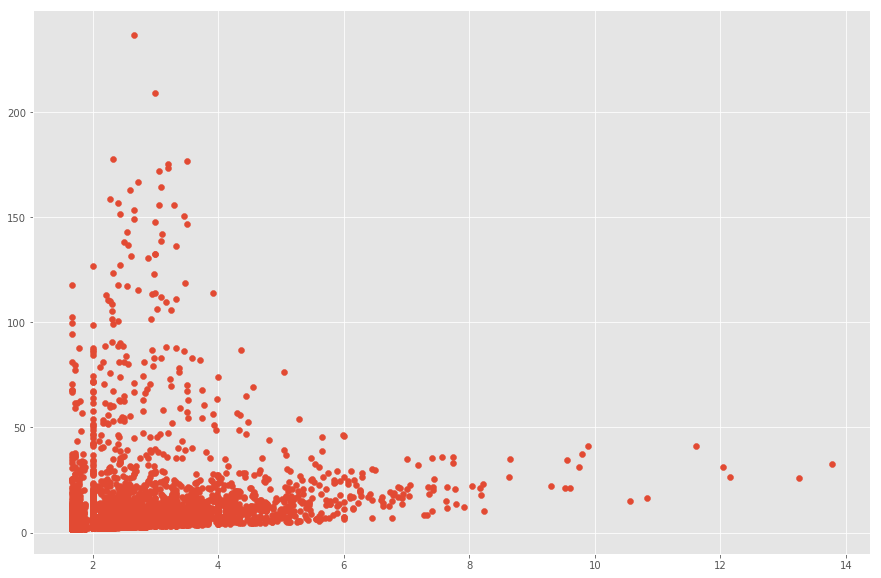

In [49]:
plt.scatter(avg_degrees, avg_weighted_degree)
plt.show()

## Conclusion
Through this tutorial we have gotten a chance to learn more about online social networks and the Youtube community. Moreover, we demonstrated some of the abilities of the Networkx package and different ways to look at networks and subgraphs, as well as visualizing them with matplotlib and Numpy. 

Thanks for reading!

## Sources
1. Data from: https://snap.stanford.edu/data/com-Youtube.html
2. Networkx Documentation: https://networkx.github.io/documentation/
3. "Defining and Evaluating Network Communities based on Ground-truth": https://arxiv.org/abs/1205.6233